In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


In [2]:
# # run this once no need to run again
# df2 = pd.read_csv('annotation/2.csv', header=None)
# df4 = pd.read_csv('annotation/4.csv', header=None)
# lab1 = pd.read_csv('annotation/labels_my-project-name_2023-11-23-11-28-38.csv', header=None)
# lab2 = pd.read_csv('annotation/labels_my-project-name_2023-11-26-12-25-12.csv', header=None)
# # concat all together
# # run this once to get proper image.
# df = pd.concat([df2, df4, lab1, lab2])
# df.columns = ['label', 'x', 'y', 'image_name', 'image_width', 'image_height']
# df['image_name'] = df['image_name'].apply(lambda name: 'images/' + name)
# df.to_csv('annotation/all.csv')

In [3]:
annotations_df =pd.read_csv('annotation/all.csv', index_col=0)


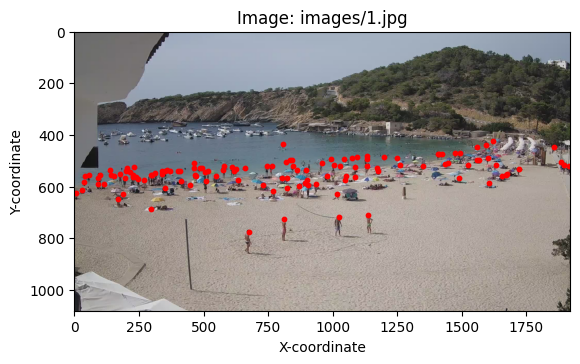

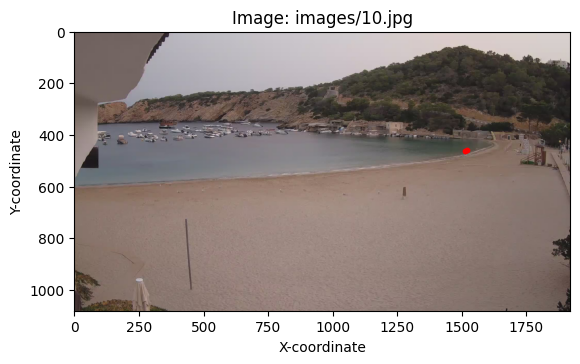

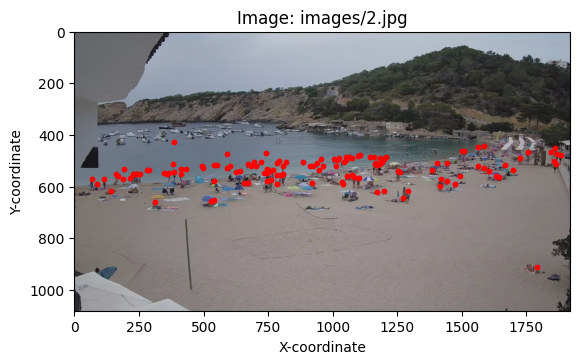

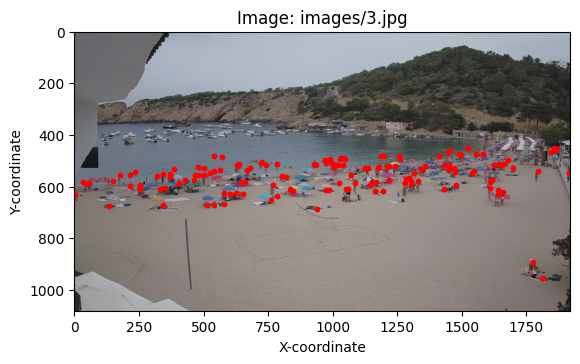

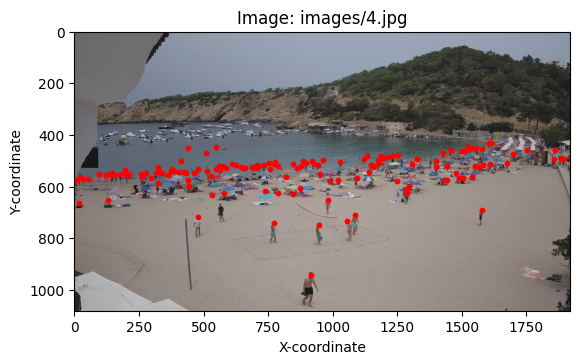

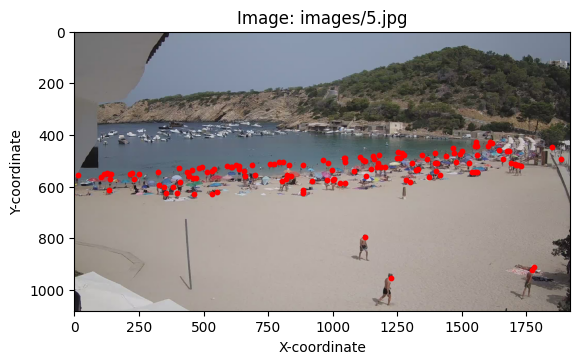

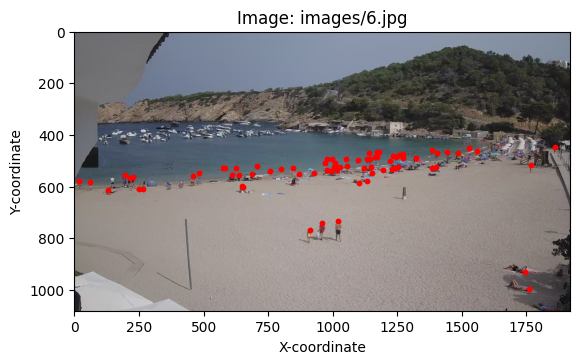

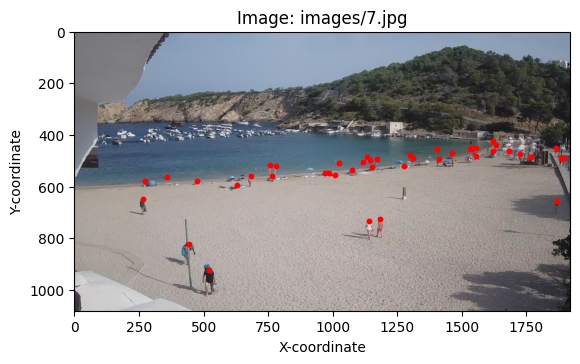

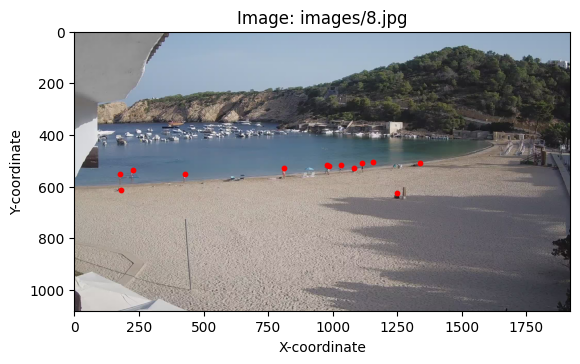

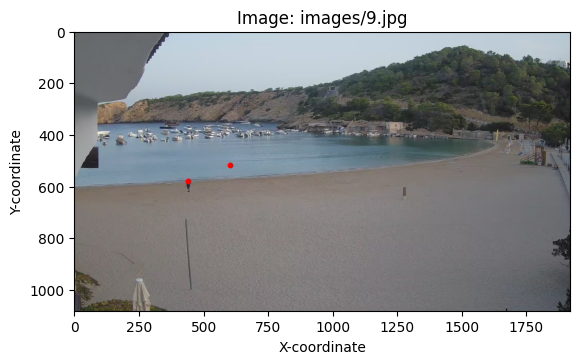

In [4]:
grouped = annotations_df.groupby("image_name")
# Iterate through each group
for image_name, group in grouped:
    # Read the image
    image = Image.open(image_name)  # Load the image using PIL

    # Create a matplotlib figure and axis
    fig, ax = plt.subplots(1)

    # Add points to the image based on "x" and "y" coordinates
    x = group["x"]
    y = group["y"]
    ax.scatter(x, y, color='red', s=10)  # You can customize the point appearance

    # Set axis limits if needed
    image_width = group.iloc[0]['image_width']
    image_height = group.iloc[0]['image_height']
    ax.set_xlim(0, image_width)
    ax.set_ylim(0, image_height)

    # Add labels or annotations if desired
    plt.title(f"Image: {image_name}")
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")

    # Show the image with points
    # Display the image with y-axis inverted
    ax.invert_yaxis()  # Invert the y-axis to display the image right-side up
    ax.imshow(image)
    plt.show()


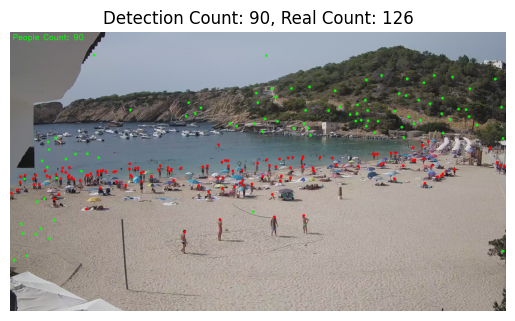

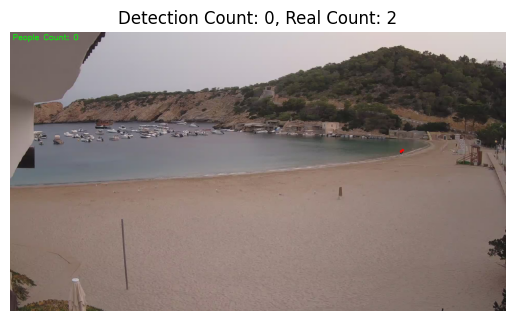

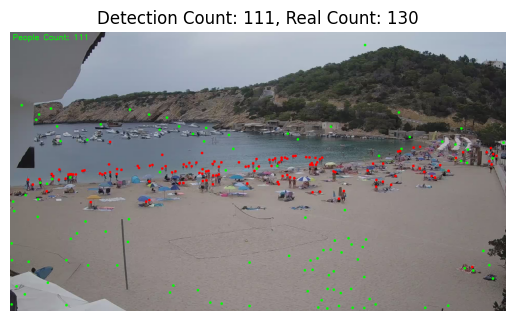

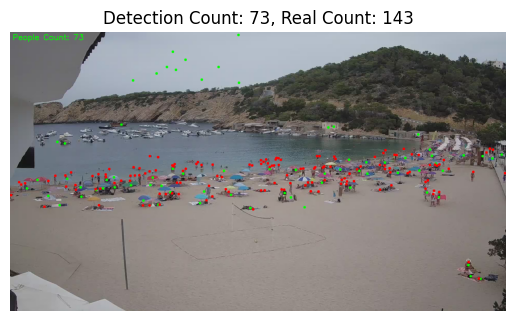

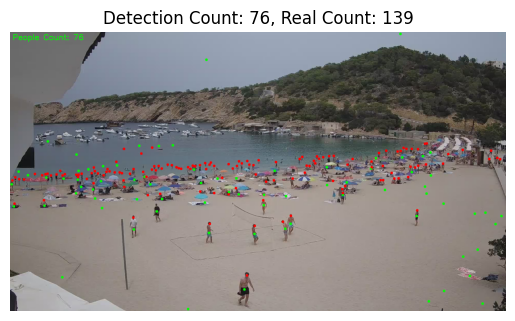

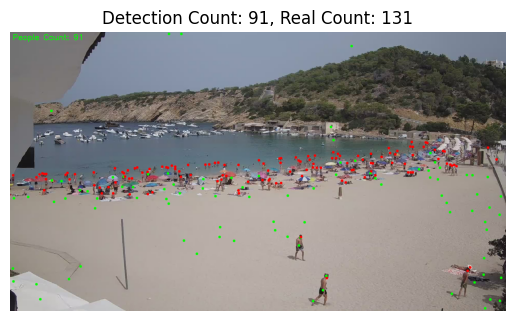

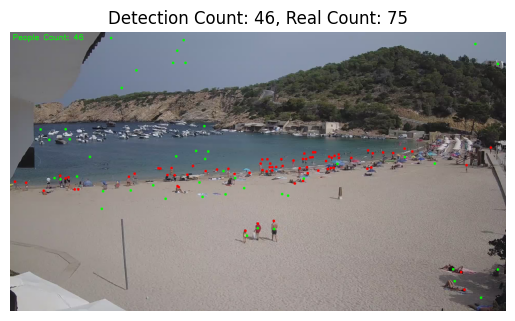

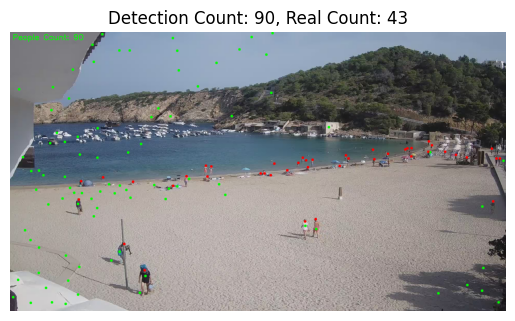

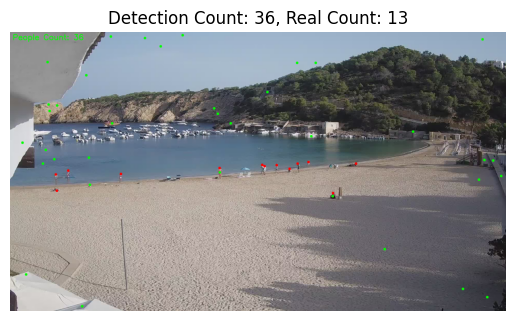

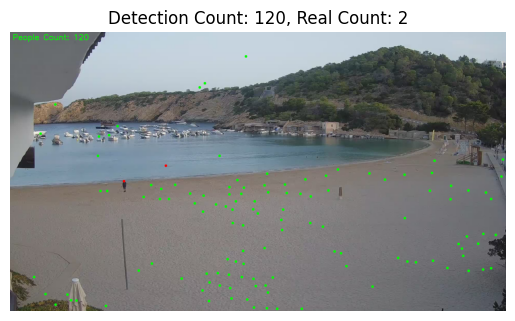

In [5]:
import cv2
import pandas as pd

# Load the two background images (images without people)
background1 = cv2.imread("images/10.jpg")
background2 = cv2.imread("images/9.jpg")

# Initialize the background subtractor with the two backgrounds
bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=16, detectShadows=True)
bg_subtractor.apply(background1, learningRate=0)
bg_subtractor.apply(background2, learningRate=0)

# Group annotations by image_name
grouped_annotations = annotations_df.groupby("image_name")
# Group annotations by image_name

image_names = []
x_values = []
y_values = []


# Iterate through each group (each image)
for image_name, group in grouped_annotations:
    # Load the current image based on the image_name
    current_image = cv2.imread(image_name)

    # Apply background subtraction
    fg_mask = bg_subtractor.apply(current_image)

    # Post-processing to remove noise and enhance the mask
    fg_mask = cv2.erode(fg_mask, None, iterations=2)
    fg_mask = cv2.dilate(fg_mask, None, iterations=2)

    # Find contours in the foreground mask
    contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize a count for detected people
    people_count = 0

    for contour in contours:
        # Ignore small contours (adjust the threshold as needed)
        if cv2.contourArea(contour) < 200:
            continue

        # Calculate the center of mass (centroid) of the contour
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
        else:
            cx, cy = 0, 0

        # Draw a dot (circle) at the centroid position
        cv2.circle(current_image, (cx, cy), 5, (0, 255, 0), -1)

        # Increment the people count
        people_count += 1

        # Append the detection count, x, and y values to the lists
        image_names.append(image_name)
        x_values.append(cx)
        y_values.append(cy)

    # Draw annotations (e.g., bounding boxes) on the image
    for _, annotation in group.iterrows():
        x, y = annotation['x'], annotation['y']
        cv2.circle(current_image, (x, y), 5, (0, 0, 255), -1)

    # Display the result with the people count and annotations
    cv2.putText(current_image, f"People Count: {people_count}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow("Image with People Count and Annotations", current_image)
    # Display the result with the people count and annotations in the Jupyter Notebook
    plt.imshow(cv2.cvtColor(current_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Detection Count: {people_count}, Real Count: {group.shape[0]}")
    plt.axis('off')
    plt.show()

result_df = pd.DataFrame({'x': x_values, 'y': y_values, 'image_name': image_names})
#
# # Release OpenCV windows
# cv2.destroyAllWindows()

In [23]:
# compare annotation with ground truth to see resulting
import numpy as np

# Load your ground truth and detection results DataFrames
annotation_df = pd.read_csv("annotation/all.csv")  # Replace with the actual file paths

# Define the distance threshold for classification
distance_threshold = 5.0  # Adjust the threshold as needed

annotation_df["found"] = False

# Iterate through each row of the result_df DataFrame
annotation_df["found"] = False

# Iterate through each row of the result_df DataFrame
for index, result_row in result_df.iterrows():
    # Calculate the Euclidean distance for each annotation point using apply
    min_dist, idx = annotation_df.apply(lambda row: (np.sqrt((row["x"] - result_row["x"]) ** 2 + (row["y"] - result_row["y"]) ** 2), row.name), axis=1).sort_values().iloc[0]

    # Check if the minimum distance satisfies the threshold
    if min_dist <= distance_threshold:
        # Mark the nearest annotation as found using the index
        annotation_df.at[idx, "found"] = True

# Count the number of true positives and false positives
true_positives = annotation_df[annotation_df["found"]]["found"].sum()
false_positives = len(result_df) - true_positives

# Count the number of false negatives
false_negatives = len(annotation_df) - true_positives

# Print the results
print("True Positives:", true_positives)
print("False Positives:", false_positives)
print("False Negatives:", false_negatives)


True Positives: 28
False Positives: 705
False Negatives: 776


In [7]:
# ! conda update -y -n base -c defaults conda
# ! conda install -y scikit-learn
# !pip install scikit-learn
